# Scaling Analysis Talapas TTbar70

Author: Brain Gravelle (gravelle@cs.uoregon.edu)


All this is using the taucmdr python libraries from paratools
http://taucommander.paratools.com/

<a href='#top'>top</a><br>
<a href='#data'>Loading Data</a><br>
<a href='#metrics'>Metrics</a><br>
<a href='#corr'>Correlations</a><br>
<a href='#stl_sb'>Store Buffer Stalls</a><br>
<a href='#fetch_stalls'>Fetch Stalls</a><br>
<a href='#l3'>l3 misses</a><br>

## Imports
This section imports necessary libraies, the metrics.py and utilities.py files and sets up the window.


<a id='top'></a>

In [1]:
# A couple of scripts to set the environent and import data from a .tau set of results
from utilities import *
from metrics import *
# Plotting, notebook settings:
%matplotlib inline  
#plt.rcParams.update({'font.size': 16})
import numbers
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.2e' % x)
pd.set_option('display.max_columns',100)
pd.set_option('max_colwidth', 70)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import copy

## Getting Data
<a id='data'></a>

TAU Commander uses TAU to run the application and measure it using runtime sampling techniques (similar to Intel VTune). Many customization options are available. For example, we may consider each function regardless of calling context, or we may decide to enable callpath profiling to see each context separately.

From the talapas_scaling application the following experiments are available. These use Talapas (with 28 thread Broadwell processors) and the build-ce (realistic) option for mkFit. The first six experiments use the --num-thr option to set the thread count which is intended to perform threading within the events. the last two add the --num-ev-thr option to set the event threads, so that all threads are used to process events in parallel and each event is processed by a single thread. 
* manual_scaling_Large_talapas		
* manual_scaling_Large_talapas_fullnode	
* manual_scaling_TTbar70_talapas		
* manual_scaling_TTbar70_talapas_fullnode
* manual_scaling_TTbar35_talapas
* manual_scaling_TTbar35_talapas_fullnode
* ev_thr_scaling_Large_talapas
* ev_thr_scaling_Large_talapas_fullnode

Additionally available in the cori_scaling application are the following. These were run on NERSC's Cori on the KNL with the default memory settings (quad - 1 NUMA domain, cache - MCDRAM as direct mapped cache). See http://www.nersc.gov/users/computational-systems/cori/running-jobs/advanced-running-jobs-options/ for more info on the KNL modes. Similar to the talapas scaling they use the build-ce option and threading within each event.
* manual_scaling_TTbar35
* manual_scaling_TTbar70
* manual_scaling_Large
* mixed_thr_scaling_Large - this is bad


### Importing Scaling Data - Talapas TTbar70 is current
Here we import the data. In this case we are using Cori data from the experiments with the threads working within each event using the TTbar70 file. Note that this box will take an hour or more to run; please go enjoy a coffee while you wait.

In [107]:
application = "talapas_scaling"
experiment  = "manual_scaling_TTbar70_talapas_fullnode"
# experiment  = "manual_scaling_Large_talapas"
# experiment = "ev_thr_scaling_Large_talapas"

# application = "cori_scaling"
# experiment  = "manual_scaling_TTbar35"
# experiment  = "manual_scaling_TTbar70"
# experiment  = "manual_scaling_Large"
# experiment  = "mixed_thr_scaling_Large"

path = ".tau/" + application + "/" + experiment + "/"
# note that this function takes a long time to run, so only rerun if you must

metric_data = get_pandas_scaling(path, callpaths=True)
    
if application == "talapas_scaling":
    metric_data = remove_erroneous_threads(metric_data,  [1, 8, 16, 32, 48, 56])
elif application == "cori_scaling":
    print(metric_data.keys())
    metric_data = remove_erroneous_threads(metric_data,  [1, 4, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256])

Found: 900 trials with 166 errors




## Adding metrics
<a id='metrics'></a>

metrics are available in metrics.py. At this time the following can be added:
* add_IPC(metrics)          - Instructions per Cycle
* add_CPI(metrics)          - Cycles per instruction
* add_VIPC(metrics)         - vector instructions per cycle
* add_VIPI(metrics)         - vector instructions per instruction (i.e. fraction of total)
* add_L1_missrate(metrics)  - miss rate for L1 cache

for scaling data please use the add_metric_to_scaling_data(data, metric_func) function to add a metric

Here we add some predeefined metrics and print the top 10 functions with the best IPC

In [139]:
# New Metric (Not working yet)
def add_DERIVED_SP_VOPO(metrics):
    if (not metrics.has_key('PAPI_SP_OPS')):
        print 'ERROR adding DERIVED_SP_VOPO to metric dictionary'
        return False
    a0 = metrics['PAPI_SP_OPS'].copy()
    a0.index = a0.index.droplevel()
    u0 = a0.unstack()
    if (not metrics.has_key('PAPI_NATIVE_FP_ARITH:128B_PACKED_SINGLE')):
        print 'ERROR adding DERIVED_SP_VOPO to metric dictionary'
        return False
    a1 = metrics['PAPI_NATIVE_FP_ARITH:128B_PACKED_SINGLE'].copy()
    a1.index = a1.index.droplevel()
    u1 = a1.unstack()
    if (not metrics.has_key('PAPI_NATIVE_FP_ARITH:256B_PACKED_SINGLE')):
        print 'ERROR adding DERIVED_SP_VOPO to metric dictionary'
        return False
    a2 = metrics['PAPI_NATIVE_FP_ARITH:256B_PACKED_SINGLE'].copy()
    a2.index = a2.index.droplevel()
    u2 = a2.unstack()
    metrics['DERIVED_SP_VOPO'] = ((u1 + u2) / (u0)).stack()

    return True

In [146]:
add_metric_to_scaling_data(metric_data, add_CPI)
add_metric_to_scaling_data(metric_data, add_IPC)
add_metric_to_scaling_data(metric_data, add_L1_missrate)
add_metric_to_scaling_data(metric_data, add_L2_missrate)

if application == 'cori_scaling': 
    llc = True
    add_metric_to_scaling_data(metric_data, add_VIPI)
else: 
    llc = False
#     add_metric_to_scaling_data(metric_data, add_DERIVED_SP_VOPO)
    
add_metric_to_scaling_data(metric_data, add_L3_missrate, llc)
add_metric_to_scaling_data(metric_data, add_DERIVED_BRANCH_MR)

print_available_metrics(metric_data, scaling=True)
print(metric_data.keys())
# To test
# metric_data[32]['DERIVED_SP_VOPO'].sort_values(by='Exclusive',ascending=False).head(10)

PAPI_L2_TCA
PAPI_TLB_DM
PAPI_VEC_DP
PAPI_L2_TCM
DERIVED_CPI
PAPI_NATIVE_FP_ARITH:256B_PACKED_SINGLE
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_NATIVE_MACHINE_CLEARS:COUNT
PAPI_DP_OPS
PAPI_RES_STL
PAPI_TOT_INS
PAPI_VEC_SP
PAPI_BR_CN
PAPI_L3_TCA
PAPI_TLB_IM
PAPI_NATIVE_FP_ARITH:128B_PACKED_SINGLE
DERIVED_L1_MISSRATE
PAPI_L3_TCM
DERIVED_L3_MISSRATE
PAPI_NATIVE_FP_ARITH:SCALAR_DOUBLE
PAPI_NATIVE_RESOURCE_STALLS:SB
PAPI_NATIVE_FP_ARITH:SCALAR_SINGLE
PAPI_BR_INS
DERIVED_L2_MISSRATE
DERIVED_SP_VOPO
PAPI_NATIVE_FP_ARITH:128B_PACKED_DOUBLE
DERIVED_BRANCH_MR
DERIVED_IPC
PAPI_LST_INS
PAPI_NATIVE_UOPS_RETIRED:STALL_CYCLES
PAPI_SP_OPS
PAPI_NATIVE_FP_ARITH:256B_PACKED_DOUBLE
PAPI_TOT_CYC
[32, 48, 56, 8, 16]


#### Combining metrics

In [147]:
THREAD_COUNT = 32

alldata = combine_metrics(metric_data[THREAD_COUNT],inc_exc='Exclusive')

## Scaling Results

In this section we carefully walk through an analysis of the application to find areas of interest.

We begin by looking at correlations of data to determine metrics of interest and then move on to ploting those metric. In this analysis we primarily use PAPI_TOT_CYC as a proxy for the time it takes a function to complete.

## Correlations
<a id='corr'></a>

In [148]:
cm = sns.light_palette("yellow", as_cmap=True)

def get_corr(alldata, method='pearson', metrics=['PAPI_TOT_CYC', 'PAPI_TOT_INS']):
    correlations = alldata.corr(method).fillna(0)[metrics]    # Other methods: 'kendall', 'spearman'
    return correlations.style.format("{:.2%}").background_gradient(cmap=cm)
    
pcorr = get_corr(alldata)
kcorr = get_corr(alldata, method='kendall')
scorr = get_corr(alldata, method='spearman')

In [143]:
metric_li = ['PAPI_TOT_CYC','PAPI_RES_STL']

corrs = [alldata.corr('pearson').fillna(0)[metric_li], alldata.corr('kendall').fillna(0)[metric_li], alldata.corr('spearman').fillna(0)[metric_li]]

corr_data = corrs[0][['PAPI_TOT_CYC']].copy()
corr_data['p_' + metric_li[0]] = corr_data[metric_li[0]]
corr_data['p_' + metric_li[1]] = corrs[0][metric_li[1]]

corr_data['k_' + metric_li[0]] = corrs[1][metric_li[0]]
corr_data['k_' + metric_li[1]] = corrs[1][metric_li[1]]

corr_data['s_' + metric_li[0]] = corrs[2][metric_li[0]]
corr_data['s_' + metric_li[1]] = corrs[2][metric_li[1]]

corr_data.drop(['PAPI_TOT_CYC'],axis=1,inplace=True)

corr_data.style.format("{:.2%}").background_gradient(cmap=cm)

,p_PAPI_TOT_CYC,p_PAPI_RES_STL,k_PAPI_TOT_CYC,k_PAPI_RES_STL,s_PAPI_TOT_CYC,s_PAPI_RES_STL
PAPI_TOT_CYC,100.00%,75.27%,100.00%,95.87%,100.00%,99.68%
PAPI_L2_TCA,93.90%,79.39%,94.96%,94.83%,99.55%,99.52%
PAPI_TLB_DM,49.36%,90.57%,91.89%,92.94%,98.98%,99.19%
PAPI_VEC_DP,21.12%,62.78%,89.09%,89.07%,98.27%,98.31%
PAPI_L2_TCM,76.68%,96.25%,94.24%,95.37%,99.43%,99.62%
DERIVED_CPI,-13.82%,-9.75%,-11.35%,-15.95%,-16.46%,-23.51%
PAPI_NATIVE_FP_ARITH:256B_PACKED_SINGLE,58.46%,-2.68%,77.54%,77.79%,82.01%,82.20%
PAPI_L1_TCM,86.26%,92.72%,95.58%,95.01%,99.45%,99.31%
PAPI_BR_MSP,89.86%,74.24%,93.35%,92.03%,99.23%,98.94%
PAPI_NATIVE_MACHINE_CLEARS:COUNT,31.79%,83.35%,93.60%,94.42%,99.32%,99.45%


### Correlation Take Aways

At first glance the correlations seem to show that cache misses (although not necessarily the miss rates) are significantly related to the numebr of stalls that occur.

## Store Buffer Stalls
<a id='stl_sb'></a>

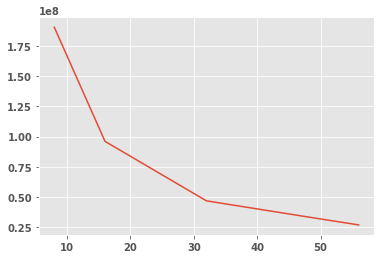

In [169]:
METRIC='PAPI_NATIVE_RESOURCE_STALLS:SB'
thread_list, STL_SB_data = scaling_plot(metric_data, plot=False, metric=METRIC)
    
plt = matplotlib.pyplot.plot(thread_list, STL_SB_data)

8


<BarContainer object of 8 artists>

(0.0, 5000000000.0)

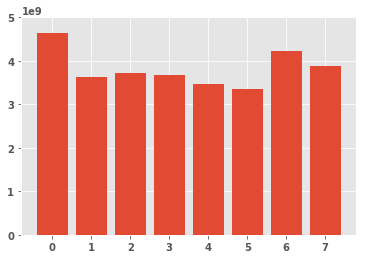

16


<BarContainer object of 16 artists>

(0.0, 5000000000.0)

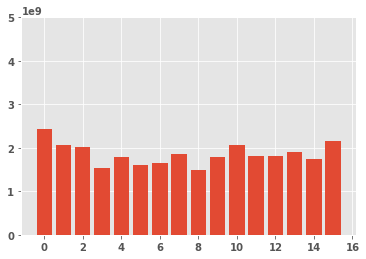

32


<BarContainer object of 32 artists>

(0.0, 5000000000.0)

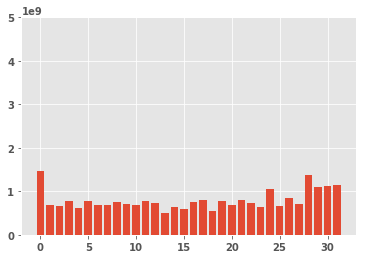

48


<BarContainer object of 48 artists>

(0.0, 5000000000.0)

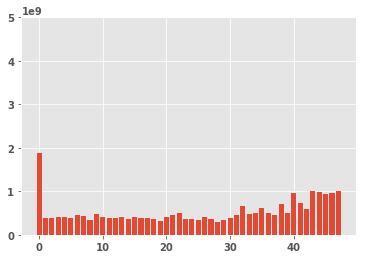

56


<BarContainer object of 56 artists>

(0.0, 5000000000.0)

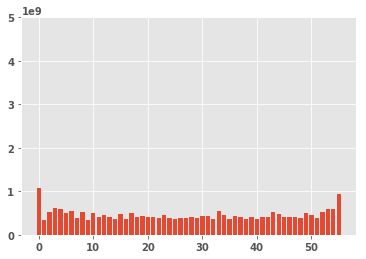

In [173]:
thread_STL_SB_data = get_thread_level_metric_scaling(metric_data, metric=METRIC)

for kt in thread_list:
    print kt
    data = list(thread_STL_SB_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=5e9)
    matplotlib.pyplot.show()

In [175]:
STL_SB_data = select_metric_from_scaling(metric_data, METRIC)
STL_SB_dict = {}
for n_thr in thread_list:
    STL_SB_dict[n_thr] = filter_libs_out(STL_SB_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[8, 16, 32, 48, 56]


In [178]:
THREAD_COUNT = 8
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(STL_SB_dict[THREAD_COUNT], func=func, avg=True).head(10)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",4.53e+07
[SUMMARY] __svml_sincosf8_l9,3.13e+07
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_sincosf8_l9,2.78e+07
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",1.85e+07
[SUMMARY] __read_nocancel,1.40e+07
[SUMMARY] Event::clean_cms_seedtracks(),1.27e+07
"[SUMMARY] RadixSort::Sort(float const*, unsigned int)",1.20e+07
"[SUMMARY] helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)",1.11e+07
"[SUMMARY] void _INTERNALc4f9cdd2::helixAtRFromIterativeCCS_impl<Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<int, 1, 1, 8>, Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<float, 1, 1, 8>, Matriplex::Matriplex<float, 6, 6, 8> >(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, int, int, bool)",1.05e+07


In [180]:
stl_sb_data = copy.deepcopy(alldata)
metric = METRIC

for m in metric_data[THREAD_COUNT].keys():
    if (not m == 'METADATA') and (not m == 'PAPI_TOT_CYC') and (not m == metric): stl_sb_data.drop([m],axis=1,inplace=True)

def filter_libs_out(dfs):
    dfs_filtered = dfs.groupby(level='region').filter(lambda x: ('.TAU application =>' not in x.name) and ('tbb' not in x.name) and ('syscall' not in x.name)  and ('std::' not in x.name))
    return dfs_filtered        

stl_sb_data = stl_sb_data.groupby(['region']).mean().sort_values(by='PAPI_TOT_CYC',ascending=False).head(100)
stl_sb_data = filter_libs_out(stl_sb_data)
stl_sb_data = stl_sb_data[stl_sb_data.index.get_level_values('region').str.contains('::')]
# vipidata.sort_values(by=metric,ascending=True).head(20)
stl_sb_data.head(20)

,PAPI_TOT_CYC,PAPI_NATIVE_RESOURCE_STALLS:SB
region,,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",2.06e+08,1.27e+07
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",6.26e+07,3.50e+06
"[SUMMARY] Matriplex::MatriplexSym<float, 3, 8>::SlurpIn(char const*, int*, int)",4.44e+07,3.41e+06
"[SUMMARY] helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)",3.67e+07,2.56e+06
[SUMMARY] Event::clean_cms_seedtracks(),3.47e+07,4.90e+05
"[SUMMARY] void _INTERNALc4f9cdd2::helixAtRFromIterativeCCS_impl<Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<int, 1, 1, 8>, Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<float, 1, 1, 8>, Matriplex::Matriplex<float, 6, 6, 8> >(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, int, int, bool)",3.24e+07,2.11e+06
"[SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::IdxChi2List const&, MkFinder::IdxChi2List const&)",3.15e+07,1.67e+06
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)",2.99e+07,1.79e+06
[SUMMARY] Track::Track(Track const&),2.83e+07,1.08e+06


## L2 Miss Count
<a id='l2'></a>

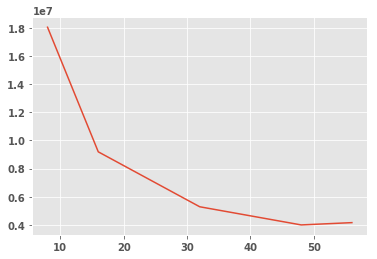

In [158]:
thread_list, L2_TCM_data = scaling_plot(metric_data, plot=False, metric='PAPI_L2_TCM')
    
plt = matplotlib.pyplot.plot(thread_list, L2_TCM_data)

8


<BarContainer object of 8 artists>

(0.0, 500000000.0)

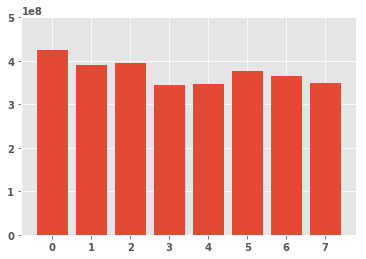

16


<BarContainer object of 16 artists>

(0.0, 500000000.0)

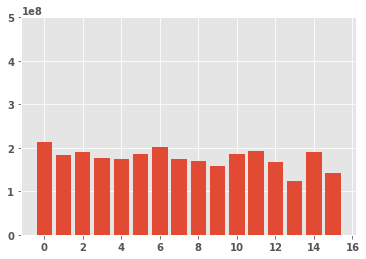

32


<BarContainer object of 32 artists>

(0.0, 500000000.0)

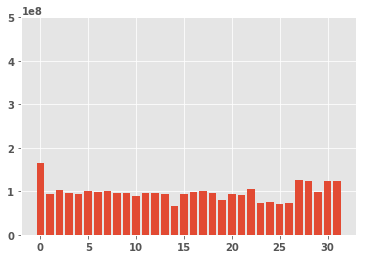

48


<BarContainer object of 48 artists>

(0.0, 500000000.0)

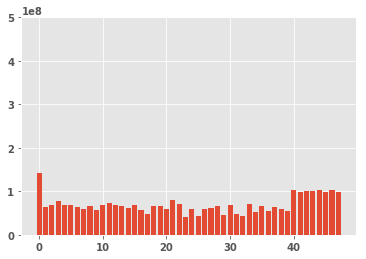

56


<BarContainer object of 56 artists>

(0.0, 500000000.0)

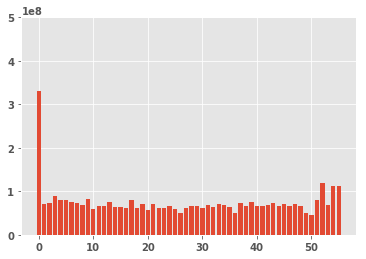

In [162]:
thread_L2_TCM_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L2_TCM')

for kt in thread_list:
    print kt
    data = list(thread_L2_TCM_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=5e8)
    matplotlib.pyplot.show()

In [164]:
L2_TCM_data = select_metric_from_scaling(metric_data, 'PAPI_L2_TCM')
L2_TCM_dict = {}
for n_thr in thread_list:
    L2_TCM_dict[n_thr] = filter_libs_out(L2_TCM_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[8, 16, 32, 48, 56]


In [165]:
THREAD_COUNT = 16
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L2_TCM_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.87e+06
[SUMMARY] __svml_sincosf8_l9,1.25e+06
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_sincosf8_l9,1.14e+06
[SUMMARY] __GI___libc_malloc,9.06e+05
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",6.57e+05
[SUMMARY] __read_nocancel,6.33e+05
[SUMMARY] Event::clean_cms_seedtracks(),6.28e+05
[SUMMARY] _int_free,5.94e+05
[SUMMARY] __intel_avx_rep_memset,4.59e+05


## L3 Miss Count
<a id='l3'></a>

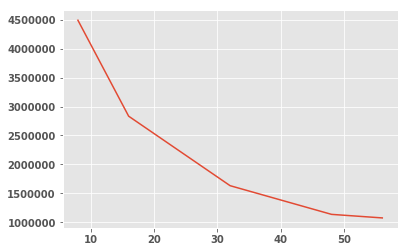

In [149]:
thread_list, L3_TCM_data = scaling_plot(metric_data, plot=False, metric='PAPI_L3_TCM')
    
plt = matplotlib.pyplot.plot(thread_list, L3_TCM_data)

8


<BarContainer object of 8 artists>

(0.0, 200000000.0)

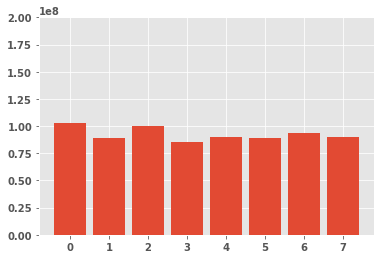

16


<BarContainer object of 16 artists>

(0.0, 200000000.0)

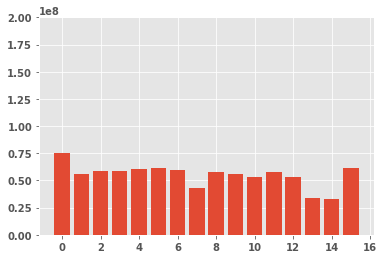

32


<BarContainer object of 32 artists>

(0.0, 200000000.0)

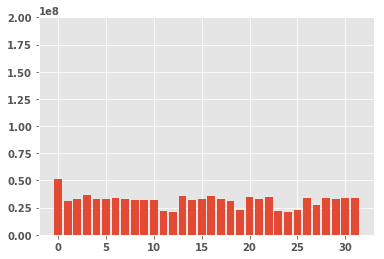

48


<BarContainer object of 48 artists>

(0.0, 200000000.0)

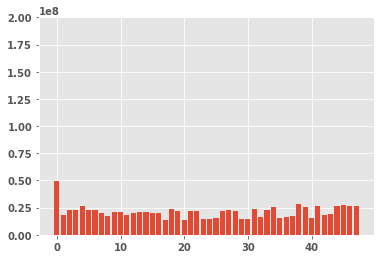

56


<BarContainer object of 56 artists>

(0.0, 200000000.0)

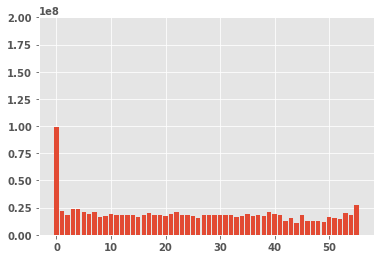

In [156]:
thread_L3_TCM_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L3_TCM')

for kt in thread_list:
    print kt
    data = list(thread_L3_TCM_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=2e8)
    matplotlib.pyplot.show()

In [153]:
L3_TCM_data = select_metric_from_scaling(metric_data, 'PAPI_L3_TCM')
L3_TCM_dict = {}
for n_thr in thread_list:
    L3_TCM_dict[n_thr] = filter_libs_out(L3_TCM_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[8, 16, 32, 48, 56]


In [157]:
THREAD_COUNT = 16
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L3_TCM_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",4.96e+05
[SUMMARY] Event::clean_cms_seedtracks(),3.08e+05
[SUMMARY] __svml_sincosf8_l9,2.90e+05
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_sincosf8_l9,2.61e+05
[SUMMARY] __GI___libc_malloc,2.52e+05
[SUMMARY] __read_nocancel,2.31e+05
[SUMMARY] _int_free,2.05e+05
"[SUMMARY] RadixSort::Sort(float const*, unsigned int)",1.85e+05
[SUMMARY] _int_malloc,1.77e+05


## Fetch Stalls
<a id='fetch_stalls'></a>

In [116]:
# thread_list, FETCH_STALL_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_FETCH_STALL')
    
# plt = matplotlib.pyplot.plot(thread_list, FETCH_STALL_data)

In [117]:
# thread_FETCH_STL_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_FETCH_STALL')

# for kt in thread_list:
#     print kt
#     data = list(thread_FETCH_STL_data[kt])
#     matplotlib.pyplot.bar(range(len(data)), data)
#     matplotlib.pyplot.ylim(ymax=2e9)
#     matplotlib.pyplot.show()

In [118]:
# FS_data = select_metric_from_scaling(metric_data, 'PAPI_NATIVE_FETCH_STALL')
# FS_dict = {}
# for n_thr in thread_list:
#     FS_dict[n_thr] = filter_libs_out(FS_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
# print thread_list

In [119]:
# THREAD_COUNT = 1
# func = 'NULL'
# # func = 'FindCandidatesCloneEngine' # NULL for nothing
# # func = 'SelectHitIndices' # NULL for nothing
# get_func_level_metric(FS_dict[THREAD_COUNT], func=func, avg=True).head(20)

## Stalls per Cycle
<a id='fetch_ratio'></a>

In [120]:
# thread_list, FETCH_STALL_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_FETCH_STALL')
# thread_list, TOT_CYC_data = scaling_plot(metric_data, plot=False, metric='PAPI_TOT_CYC')
    
# FS_P_CYC_list = [FETCH_STALL_data[i] / TOT_CYC_data[i] for i in range(len(thread_list))]

# plt = matplotlib.pyplot.plot(thread_list, FS_P_CYC_list)

In [121]:
# thread_TOT_CYC_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_TOT_CYC')
# thread_FETCH_STL_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_FETCH_STALL')

# FS_P_CYC_data = {}
# for kt in thread_list:
# #     print(thread_L1M_data[kt])
# #     print(thread_L1A_data[kt])
#     FS_P_CYC_data[kt] = thread_FETCH_STL_data[kt] / thread_TOT_CYC_data[kt]
     
# for kt in thread_list:
#     print kt
#     data = list(FS_P_CYC_data[kt])
#     matplotlib.pyplot.bar(range(len(data)), data)
#     matplotlib.pyplot.ylim(ymax=0.2)
#     matplotlib.pyplot.show()

In [122]:
# FSTC_data = select_metric_from_scaling(metric_data, 'DERIVED_RATIO_FETCH_STL_TOT_CYC')
# FSTC_dict = {}


# def filter_libs_out_2(dfs):
#     dfs_filtered = dfs.groupby(level='region').filter(lambda x: ('.TAU application ' not in x.name) and ('tbb' not in x.name) and ('syscall' not in x.name)  and ('std::' not in x.name))
#     return dfs_filtered

# for n_thr in thread_list:
#     FSTC_dict[n_thr] = filter_libs_out_2(FSTC_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
# #     FSTC_dict[n_thr] = FSTC_data[n_thr].sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
# print thread_list

In [123]:
# THREAD_COUNT = 32
# func = 'NULL'
# # func = 'FindCandidatesCloneEngine' # NULL for nothing
# # func = 'SelectHitIndices' # NULL for nothing
# get_func_level_metric(FSTC_dict[THREAD_COUNT], func=func, avg=True).head(10)